# Section 4.1 StrategyQA Classification with ModernBERT - Head-Tuned Classifier

## Setup and Imports

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Load StrategyQA Dataset

In [35]:
ds = load_dataset("wics/strategy-qa", revision="refs/convert/parquet")
source = ds["test"]
SEED = 42

questions = source['question']
answers = source['answer']
facts = source['facts']
decompositions = source['decomposition']
qids = source['qid']
terms = source['term']
descriptions = source['description']

answer_ints = [1 if ans else 0 for ans in answers]

train_indices, temp_indices = train_test_split(
    range(len(source)),
    test_size=0.20,
    random_state=42,
    stratify=answer_ints
)

temp_answer_ints = [answer_ints[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.50,
    random_state=42,
    stratify=temp_answer_ints
)

def create_dataset_from_indices(indices):
    return {
        'question': [questions[i] for i in indices],
        'answer': [answers[i] for i in indices],
        'facts': [facts[i] for i in indices],
        'decomposition': [decompositions[i] for i in indices],
        'qid': [qids[i] for i in indices],
        'term': [terms[i] for i in indices],
        'description': [descriptions[i] for i in indices]
    }

train_data = create_dataset_from_indices(train_indices)
val_data = create_dataset_from_indices(val_indices)
test_data = create_dataset_from_indices(test_indices)


from datasets import Dataset
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)


dataset = DatasetDict(train=train_dataset, validation=val_dataset, test=test_dataset)


print(f"Train: {len(dataset['train'])} samples")
print(f"Validation: {len(dataset['validation'])} samples")
print(f"Test: {len(dataset['test'])} samples")

max_length = 256

train_dataset = dataset['train']
val_dataset = dataset['validation']


Train: 1832 samples
Validation: 229 samples
Test: 229 samples


## Load ModernBERT Model and Tokenizer

In [36]:
model_name = "answerdotai/ModernBERT-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")

for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")


model = model.to(device)
model.eval()



Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 149,606,402
Vocabulary size: 50,280
Frozen parameters: 149,604,864 (100.0%)
Trainable parameters: 1,538 (0.0%)


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

## Training Configuration

In [37]:
def collate_fn(batch):
    """
    Collate function to tokenize and batch the data
    """
    questions = [item['question'] for item in batch]
    answers = [item['answer'] for item in batch]
    facts = []
    for item in batch:
        facts.append(" ".join(s for s in item['facts'] if isinstance(s, str)))

    encoding = tokenizer(
        questions,
        facts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors='pt'
    )

    labels = []
    for answer in answers:
        if isinstance(answer, bool):
            label = 1 if answer else 0
        elif isinstance(answer, str):
            label = 1 if answer.lower() == 'yes' else 0
        else:
            label = 0
        labels.append(label)

    labels = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'label': labels
    }


BATCH_SIZE = 16
LEARNING_RATE = 5e-5
NUM_EPOCHS = 50
WARMUP_STEPS = 50
MAX_GRAD_NORM = 1.0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)


## Training Functions

In [38]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    """
    Train for one epoch
    """
    model.train()
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)


        loss.backward()
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        torch.nn.utils.clip_grad_norm_(trainable_params, MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()


        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        progress_bar.set_postfix({
            'Acc': f'{100 * correct / total:.2f}%'
        })

    return 100 * correct / total

def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)


            outputs = model(input_ids, attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return  100 * correct / total


## Training Loop

In [39]:

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}")

    train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device
    )
    val_acc = evaluate(
        model, val_loader, criterion, device
    )



    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    print(f"Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}%")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best validation accuracy: {best_val_acc:.2f}%")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_strategyqa_head_only.pth')

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")



Epoch 1


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


Train Acc: 49.67%
Val Acc: 48.03%
New best validation accuracy: 48.03%

Epoch 2


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.39it/s]


Train Acc: 49.34%
Val Acc: 48.47%
New best validation accuracy: 48.47%

Epoch 3


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


Train Acc: 50.49%
Val Acc: 46.29%

Epoch 4


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.67it/s]


Train Acc: 52.13%
Val Acc: 46.72%

Epoch 5


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


Train Acc: 52.02%
Val Acc: 46.29%

Epoch 6


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.53it/s]


Train Acc: 53.55%
Val Acc: 49.34%
New best validation accuracy: 49.34%

Epoch 7


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.74it/s]


Train Acc: 53.33%
Val Acc: 50.66%
New best validation accuracy: 50.66%

Epoch 8


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.33it/s]


Train Acc: 55.19%
Val Acc: 49.78%

Epoch 9


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.40it/s]


Train Acc: 54.48%
Val Acc: 51.97%
New best validation accuracy: 51.97%

Epoch 10


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.28it/s]


Train Acc: 55.13%
Val Acc: 50.66%

Epoch 11


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.79it/s]


Train Acc: 55.19%
Val Acc: 51.97%

Epoch 12


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.15it/s]


Train Acc: 55.68%
Val Acc: 53.71%
New best validation accuracy: 53.71%

Epoch 13


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.13it/s]


Train Acc: 56.60%
Val Acc: 53.71%

Epoch 14


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.10it/s]


Train Acc: 57.04%
Val Acc: 53.28%

Epoch 15


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


Train Acc: 57.64%
Val Acc: 53.71%

Epoch 16


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


Train Acc: 57.81%
Val Acc: 52.40%

Epoch 17


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.91it/s]


Train Acc: 58.52%
Val Acc: 52.84%

Epoch 18


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.83it/s]


Train Acc: 58.41%
Val Acc: 53.28%

Epoch 19


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.49it/s]


Train Acc: 59.39%
Val Acc: 52.40%

Epoch 20


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


Train Acc: 59.55%
Val Acc: 53.71%

Epoch 21


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.84it/s]


Train Acc: 59.33%
Val Acc: 53.71%

Epoch 22


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.11it/s]


Train Acc: 60.37%
Val Acc: 52.40%

Epoch 23


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.56it/s]


Train Acc: 60.04%
Val Acc: 53.71%

Epoch 24


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.97it/s]


Train Acc: 60.64%
Val Acc: 53.71%

Epoch 25


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.79it/s]


Train Acc: 61.63%
Val Acc: 53.28%

Epoch 26


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.54it/s]


Train Acc: 61.30%
Val Acc: 55.02%
New best validation accuracy: 55.02%

Epoch 27


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.97it/s]


Train Acc: 61.68%
Val Acc: 55.02%

Epoch 28


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.05it/s]


Train Acc: 61.57%
Val Acc: 54.59%

Epoch 29


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.30it/s]


Train Acc: 61.57%
Val Acc: 55.02%

Epoch 30


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.15it/s]


Train Acc: 62.39%
Val Acc: 55.46%
New best validation accuracy: 55.46%

Epoch 31


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.32it/s]


Train Acc: 62.17%
Val Acc: 55.90%
New best validation accuracy: 55.90%

Epoch 32


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Train Acc: 61.95%
Val Acc: 55.02%

Epoch 33


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.74it/s]


Train Acc: 62.17%
Val Acc: 55.02%

Epoch 34


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.91it/s]


Train Acc: 62.34%
Val Acc: 55.02%

Epoch 35


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.17it/s]


Train Acc: 62.55%
Val Acc: 55.02%

Epoch 36


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.32it/s]


Train Acc: 62.55%
Val Acc: 55.02%

Epoch 37


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.75it/s]


Train Acc: 62.34%
Val Acc: 54.59%

Epoch 38


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


Train Acc: 62.72%
Val Acc: 55.46%

Epoch 39


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


Train Acc: 62.61%
Val Acc: 54.15%

Epoch 40


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.83it/s]


Train Acc: 62.88%
Val Acc: 54.15%

Epoch 41


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.25it/s]


Train Acc: 62.83%
Val Acc: 54.59%

Epoch 42


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.96it/s]


Train Acc: 63.05%
Val Acc: 54.59%

Epoch 43


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.77it/s]


Train Acc: 63.05%
Val Acc: 54.59%

Epoch 44


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.16it/s]


Train Acc: 63.54%
Val Acc: 54.59%

Epoch 45


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.68it/s]


Train Acc: 63.21%
Val Acc: 54.59%

Epoch 46


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.88it/s]


Train Acc: 63.21%
Val Acc: 54.59%

Epoch 47


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.94it/s]


Train Acc: 63.59%
Val Acc: 55.02%

Epoch 48


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.90it/s]


Train Acc: 63.37%
Val Acc: 54.15%

Epoch 49


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.84it/s]


Train Acc: 63.43%
Val Acc: 54.59%

Epoch 50


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.95it/s]

Train Acc: 63.32%
Val Acc: 54.59%

Training completed!
Best validation accuracy: 55.90%


## Test Set Evaluation

In [43]:

if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:

    checkpoint = torch.load('best_strategyqa_head_only.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.2f}%")

test_dataset = dataset['test']
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Test dataset: {len(test_dataset)} samples")
print(f"Test batches: {len(test_loader)}")

test_acc = evaluate(model, test_loader, criterion, device)

print("\n")
print("Final Result")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")


Test dataset: 229 samples
Test batches: 15


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 30.13it/s]



Final Result
Test Accuracy: 57.64%
Best validation accuracy: 55.90%
Final training accuracy: 63.32%
Final validation accuracy: 54.59%


## Plot Training Result

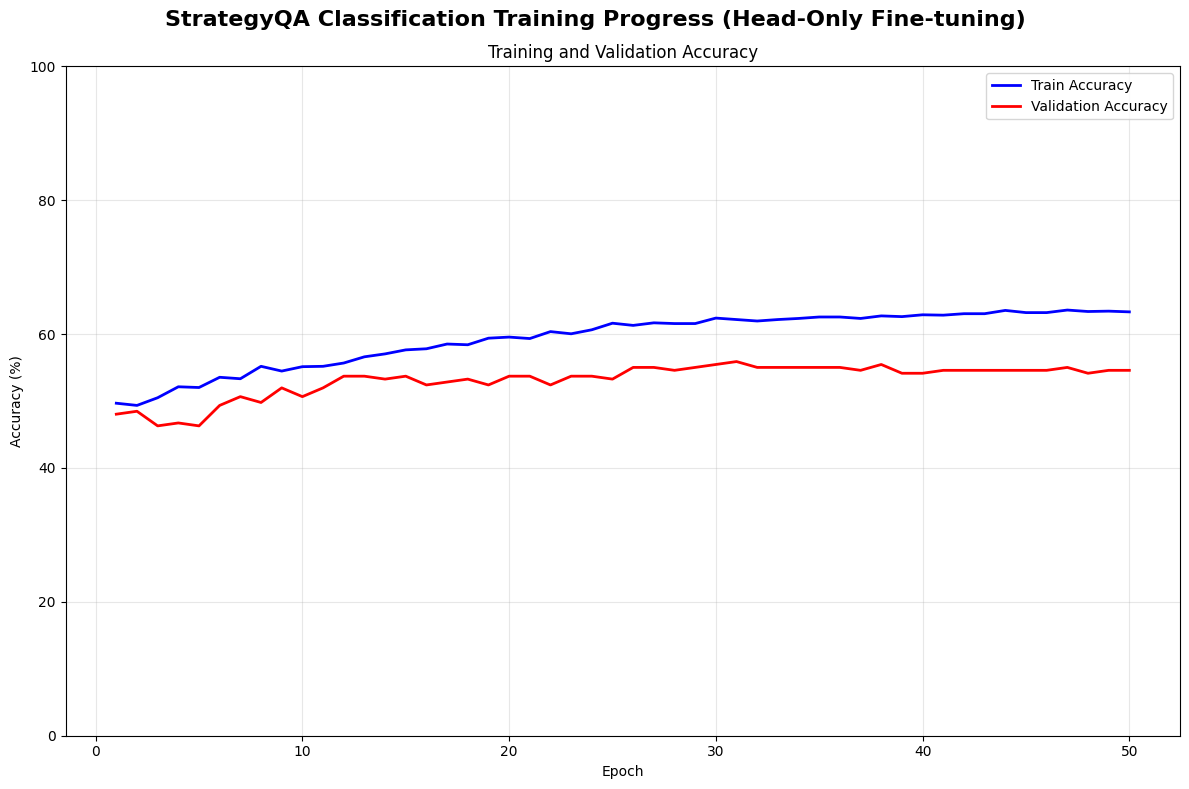

In [44]:

import matplotlib.pyplot as plt
import os


os.makedirs('results', exist_ok=True)


fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('StrategyQA Classification Training Progress (Head-Only Fine-tuning)',
             fontsize=16, fontweight='bold')

epochs = range(1, len(train_accuracies) + 1)

ax.plot(epochs, train_accuracies, linewidth=2, markersize=6, label='Train Accuracy', color='blue')
ax.plot(epochs, val_accuracies, linewidth=2, markersize=6, label='Validation Accuracy', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training and Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

fig.tight_layout()
plot_path = 'results/strategyqa_head_only_training.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()


## Download Plots

In [42]:

from google.colab import files

files.download('results/strategyqa_head_only_training.png')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>